Extrapolation/vertices/station12/h_verticalPos_vs_time
Extrapolation/vertices/station12/h_verticalPos_vs_time
Extrapolation/vertices/station18/h_verticalPos_vs_time
Extrapolation/vertices/station18/h_verticalPos_vs_time
Extrapolation/vertices/station12/h_radialPos_vs_time
Extrapolation/vertices/station12/h_radialPos_vs_time
Extrapolation/vertices/station18/h_radialPos_vs_time
Extrapolation/vertices/station18/h_radialPos_vs_time


Warning in <TCanvas::Constructor>: Deleting canvas with same name: 
Info in <TCanvas::Print>: png file ComparisionPlots4.png has been created


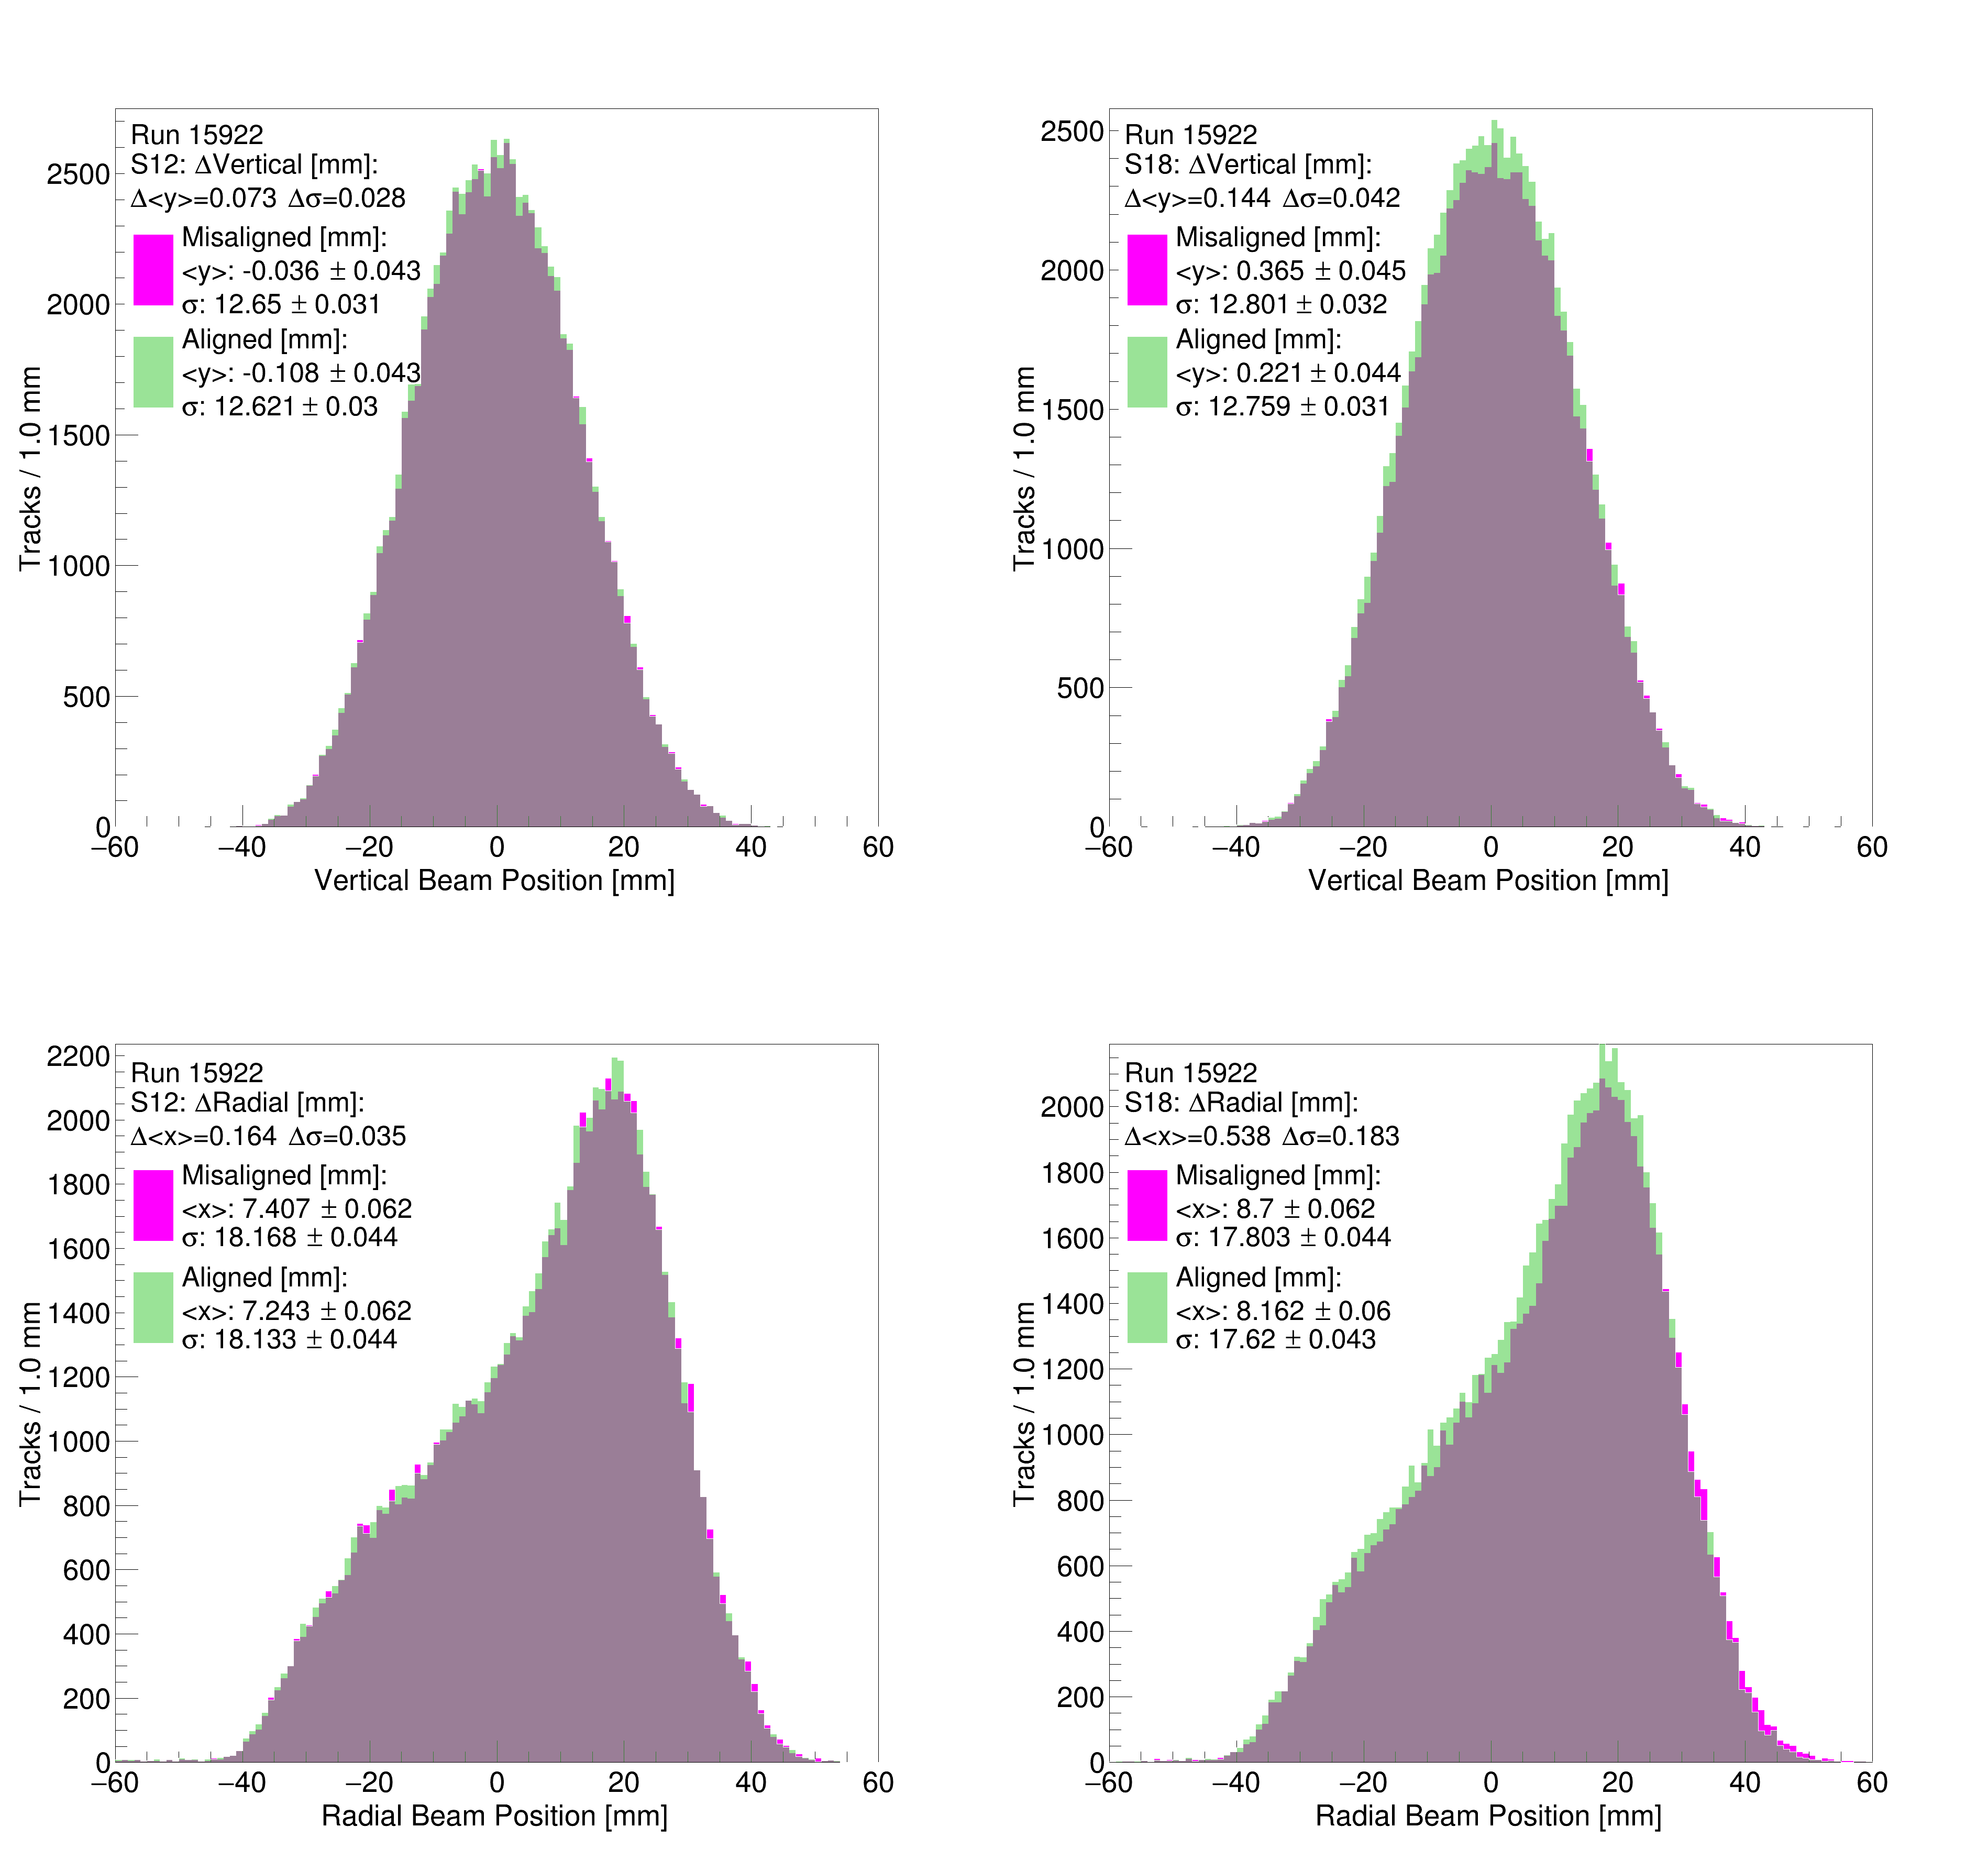

In [5]:
import sys
sys.path.append("/usr/local/Cellar/root/6.16.00_3/lib/root")
from ROOT import TFile, TStyle, TCanvas, gStyle, TF1, gROOT
import matplotlib.pyplot as plt #for plotting 
import numpy as np  # smart arrays 
import itertools # smart lines 
import argparse, sys
from math import log10, floor
from matplotlib.ticker import MaxNLocator
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from matplotlib._png import read_png
import subprocess
def round_sig(x, sig=2):
	return round(x, sig-int(floor(log10(abs(x))))-1)

from ROOT import TH1F, TH2F, TF1, TCanvas, TFile, gStyle, TPaveText, TLegend
from decimal import *
round_to = 3
getcontext().prec = round_to

#Define constant paths and labels 
path =  "Extrapolation/vertices/station"
TfileName = "gm2tracker_ana.root"
stationName = ["12", "18"]
scr_nominal= "/Users/gleb/software/alignTrack/mpIIDESY/15922_Iter1/"
scr_shift = "/Users/gleb/software/alignTrack/mpIIDESY/15922_Iter3/"

#Containers to store histograms in orders as the names 
names = ["Misaligned [mm]:", "Aligned [mm]:"]
stateN=len(names)

colors = [6, 8] #purple, green 
styles = [3001, 3002]

plotName = ["h_verticalPos_vs_time", "h_radialPos_vs_time"]
plotXtitle = ["Vertical Beam Position", "Radial Beam Position"]
plotTitle = ["#DeltaVertical [mm]:", "#DeltaRadial [mm]:"]
plotMean = ["<y>", "<x>"]
units = ["mm", "mm"]

meanArray=[] # for the final FoM shift-nominal 
sdArray=[] # for the final FoM shift-nominal 

#Make new canvas for plots 
c = TCanvas("", "", 3800, 3600)
c.Divide(2,2)
#Keep legend, histots and TFiles in scope 
legendArray=[]
histArray=[]
fileArray=[]

i_total=0 # canvas id counter 
for i_plot in range(0, len(plotName)):
    for i_station in range(0, len(stationName)):

        #Open TFiles
        scrFile_nominal = TFile.Open(scr_nominal+TfileName)
        scrFile_shift = TFile.Open(scr_shift+TfileName)
        fileName = [scrFile_nominal, scrFile_shift] # nominal (0) and global shift (1)  
        fileArray.append(fileName)

        c.cd(i_total+1)
        legend =  TLegend(0.11,0.55,0.35,0.89)
        legendArray.append(legend) # stroe all to keep in scope 
        for i_state in range(0, stateN):
           
            #Get the TH2F 
            print(path+stationName[i_station]+"/"+plotName[i_plot])
            histo_2D = fileName[i_state].Get(str(path+stationName[i_station]+"/"+plotName[i_plot]))
            #Apply 30 us time cut 
            first_bin = histo_2D.GetXaxis().FindBin(30.0)
            tmpNameTH1 = "tmpNameTH1_"+str(i_plot)+str(i_station)+str(i_state) # assign a new "name pointer" to the TH1 object for each loop 
            
            #Get the TH1F
            plot = histo_2D.ProjectionY(tmpNameTH1, first_bin, -1)
            histArray.append(plot)
            plot.GetXaxis().SetRangeUser(-60.0, 60.0) 
            mean=plot.GetMean()
            mean_error = plot.GetMeanError()
            sd=plot.GetRMS()
            sd_error=plot.GetRMSError()
            meanArray.append(mean)
            sdArray.append(sd)

            
            plot.SetLineColor(0)
            plot.SetFillStyle(1)
            plot.SetTitle("")
            plot.GetXaxis().CenterTitle()
            plot.GetXaxis().SetTitleOffset(1.1)
            binN=plot.GetBinWidth(1)
            plot.GetYaxis().SetTitle("Tracks / "+str(binN)+" "+ units[i_plot])
            plot.GetXaxis().SetTitle(plotXtitle[i_plot]+ " ["+units[i_plot]+"]")            
            plot.GetYaxis().CenterTitle()
            plot.GetYaxis().SetTitleOffset(1.6)
            
            
            if (i_state == 0):
                plot.SetFillColorAlpha(colors[i_state], 1.0)
                plot.Draw("")
                
            else:
                plot.SetFillColorAlpha(colors[i_state], 0.6)
                plot.Draw("same")
            
            #fill legend once per state      
            legenValue1 = "#splitline{"+str(names[i_state])+"}{"+plotMean[i_plot]+": "+str(round(mean, round_to))+" #pm "+str(round(mean_error,round_to))+"}"
            legenValue2 = "#sigma: "+str(round(sd,round_to))+" #pm "+str(round(sd_error,round_to))
            legend.AddEntry(plot, "#splitline{"+str(legenValue1)+"}{"+str(legenValue2)+"}", "f")
        
        #draw legend once per canvas 
        legendH1="#splitline{Run 15922}{S"+stationName[i_station]+": "+plotTitle[i_plot]+"}"
        legendH2="#Delta"+plotMean[i_plot]+"="+str(round(meanArray[0]-meanArray[1], round_to))+" #Delta#sigma="+str(round(sdArray[0]-sdArray[1], round_to))
        legend.SetHeader("#splitline{"+legendH1+"}{"+legendH2+"}", "")
        legend.Draw("same")
        i_total+=1
        meanArray=[]
        sdArray=[]
        gStyle.SetOptStat(0) 
        gStyle.SetOptFit(0)
        gStyle.SetLegendBorderSize(0)
        gStyle.SetLegendTextSize(0.033)

c.Draw()
c.Print("ComparisionPlots"+str(i_total)+".png")
